In [ ]:
!pip install kaggle -q

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir ~/.kaggle

In [ ]:
cp /content/drive/MyDrive/ColabNotebooks/kaggle.json ~/.kaggle

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images -q

In [ ]:
!unzip alzheimers-dataset-4-class-of-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem207.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem208.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem209.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem21.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem210.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem211.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem212.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem213.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem214.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem215.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem216.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem217.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem218.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/m

In [ ]:
!pip install tensorflow -q


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os 
import tqdm
import glob
import tensorflow
import Alzheimer_s_Dataset

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
from keras import optimizers

from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

#import tensorflow_addons as tfa
#from tensorflow.keras.metrics import Metric
#from tensorflow_addons.utils.types import AcceptableDTypes, FloatTensorLike
from typeguard import typechecked
from typing import Optional

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [ ]:
#train_dataset = tf.keras.preprocessing.image_dataset_from_directory('../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
#                                                                        validation_split=0.2,
#                                                                        subset="training",
#                                                                        shuffle=False,
#                                                                        image_size=(224,224),
#                                                                        batch_size=32,
#                                                                        )

train_dataset  = train_datagen.flow_from_directory(directory = '/content/Alzheimer_s_Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 32)

Found 4098 images belonging to 4 classes.


In [ ]:
#valid_dataset = tf.keras.preprocessing.image_dataset_from_directory('../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
#                                                                        validation_split=0.2,
#                                                                        subset="validation",
#                                                                        shuffle=False,
#                                                                        image_size=(224,224),
#                                                                        batch_size=32,
#                                                                        )
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/Alzheimer_s_Dataset/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 32)

Found 1023 images belonging to 4 classes.


In [ ]:
#test_dataset = tf.keras.preprocessing.image_dataset_from_directory("../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test",
##                                                            shuffle=False,
#                                                            image_size=(224,224),
#                                                            batch_size=32,
#)

test_dataset = test_datagen.flow_from_directory(directory = '/content/Alzheimer_s_Dataset/test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 32)

Found 1279 images belonging to 4 classes.


In [ ]:
base_model = ResNet50(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [ ]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(4,activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 batch_normalization (BatchN  (None, 100352)           401408    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 64)                6422592   
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                        

In [ ]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 5) # when i run it for 50 epochs

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=METRICS)

In [ ]:
history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 20,
                        verbose = 1,
                         callbacks=lr_scheduler)

Epoch 1/20
129/129 [==============================] - 70s 410ms/step - loss: 1.0841 - accuracy: 0.7538 - precision: 0.5169 - recall: 0.2350 - auc: 0.7724 - f1_score: 0.3166 - val_loss: 1.0153 - val_accuracy: 0.7590 - val_precision: 0.5188 - val_recall: 0.4985 - val_auc: 0.8299 - val_f1_score: 0.5089 - lr: 0.0100
Epoch 2/20
129/129 [==============================] - 50s 384ms/step - loss: 1.0468 - accuracy: 0.7559 - precision: 0.5327 - recall: 0.1928 - auc: 0.7809 - f1_score: 0.2702 - val_loss: 1.0277 - val_accuracy: 0.7791 - val_precision: 0.7245 - val_recall: 0.1877 - val_auc: 0.7832 - val_f1_score: 0.2958 - lr: 0.0063
Epoch 3/20
129/129 [==============================] - 51s 391ms/step - loss: 1.0344 - accuracy: 0.7618 - precision: 0.5669 - recall: 0.2006 - auc: 0.7885 - f1_score: 0.2924 - val_loss: 0.9982 - val_accuracy: 0.7884 - val_precision: 0.7625 - val_recall: 0.2229 - val_auc: 0.7987 - val_f1_score: 0.3427 - lr: 0.0040
Epoch 4/20
129/129 [==============================] - 49s 

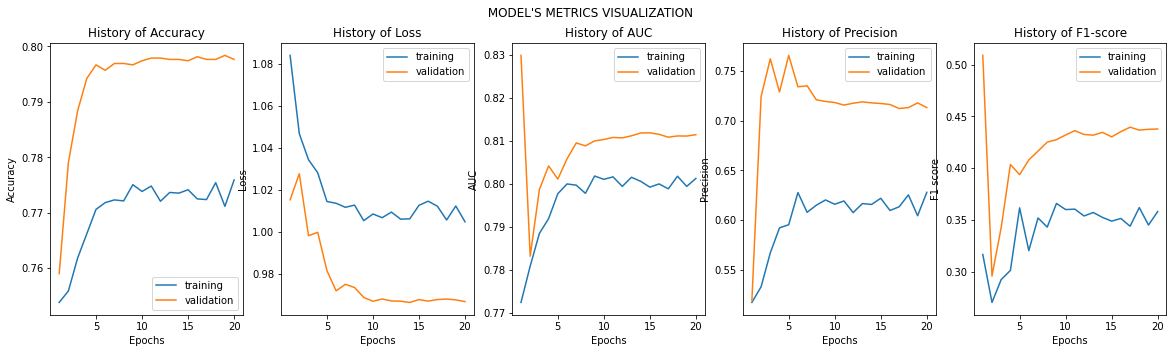

In [ ]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [ ]:
scores = model.evaluate_generator(test_dataset)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
print("Accuracy = ", scores[1])
print("Precision = ", scores[2])
print("Recall = ", scores[3])
print("AUC = ", scores[4])
print("F1_score = ", scores[5])

Accuracy =  0.7541047930717468
Precision =  0.6329113841056824
Recall =  0.03909303992986679
AUC =  0.7970337271690369
F1_score =  0.07136987894773483


In [ ]:
kpred = model.predict(test_dataset)

In [ ]:
pred = kpred.tolist()
predictions = []
for i in pred:
  predictions.append(i.index(max(i)))

In [ ]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [ ]:
print(classification_report(test_dataset.classes,predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       179
           1       0.00      0.00      0.00        12
           2       0.50      0.80      0.61       640
           3       0.34      0.19      0.24       448

    accuracy                           0.46      1279
   macro avg       0.21      0.25      0.21      1279
weighted avg       0.37      0.46      0.39      1279



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
cf_matrix=confusion_matrix(test_dataset.classes,predictions)
cf_matrix

array([[  0,   0, 145,  34],
       [  0,   0,   9,   3],
       [  0,   0, 509, 131],
       [  0,   0, 363,  85]])